In [1]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn.apionly as sns

# ignore pandas warnings
import warnings
warnings.simplefilter('ignore')

import time
start = time.time()

In [2]:
# load data
data = pd.read_csv('training_ultrasound.csv')

# remove agedays > 0 ( we just only focus pre-birth measurements)
data = data[data['AGEDAYS']<0]

# drop rows with missing data in any of the 5 main columns
ultrasound = ['HCIRCM', 'ABCIRCM', 'BPDCM', 'FEMURCM']
aux_measure = ['SEXN', 'PARITY', 'GRAVIDA']
target = 'BWT_40'
data.dropna(subset=ultrasound+[target], inplace=True)

# correct faulty data
data.loc[data['STUDYID']==2, 'PARITY'] = data.loc[data['STUDYID']==2, 'PARITY'] + 1

In [3]:
data = data.drop_duplicates(subset=(ultrasound+['SUBJID']))

## Model

In [4]:
# select basic vars
df = data[['SUBJID', 'GAGEDAYS'] + ultrasound + aux_measure + [target]]

In [5]:
df.isnull().sum()

SUBJID        0
GAGEDAYS      0
HCIRCM        0
ABCIRCM       0
BPDCM         0
FEMURCM       0
SEXN          0
PARITY      101
GRAVIDA     101
BWT_40        0
dtype: int64

In [6]:
# there is missing data for parity and gravida: this happens for first pregnancy --> fill with 1s
df.fillna(1, inplace=True)

# replace sex values to 0 and 1
df['SEXN'] = df['SEXN'].replace([1,2], [0,1])

In [7]:
df = df.merge(df.groupby('SUBJID')[['SUBJID']].count(),
                  how='left',left_on='SUBJID',right_index=True,suffixes=('', '_count'))

### Feature engineering 

In [8]:
ultrasound

['HCIRCM', 'ABCIRCM', 'BPDCM', 'FEMURCM']

In [9]:
length_ratios = ['HCIRCM / ABCIRCM', 'HCIRCM / BPDCM', 'HCIRCM / FEMURCM',
                 'ABCIRCM / BPDCM', 'ABCIRCM / FEMURCM', 
                 'BPDCM / FEMURCM']
for ratio in length_ratios:
    df[ratio] = df[ratio.split(' ')[0]] / df[ratio.split(' ')[2]]

In [10]:
lenght_time = list()
for m in ultrasound:
    col_name = '%s / GAGEDAYS' % m
    lenght_time.append(col_name)
    df[col_name] = df[m] / df['GAGEDAYS']

lenght_time

['HCIRCM / GAGEDAYS',
 'ABCIRCM / GAGEDAYS',
 'BPDCM / GAGEDAYS',
 'FEMURCM / GAGEDAYS']

In [11]:
# no of past pregancies
df['past_gest'] = df['PARITY'] - df['GRAVIDA']

other_feat = ['past_gest'] 

In [12]:
# common models for sonographic fetal weight estimation use log of the weight
df['BWT_40'] = np.log(1 + df['BWT_40'])

In [13]:
print('Dataframe size: %s,%s' % (df.shape[0],df.shape[1]))

Dataframe size: 6841,22


In [14]:
df.head()

,SUBJID,GAGEDAYS,HCIRCM,ABCIRCM,BPDCM,FEMURCM,SEXN,PARITY,GRAVIDA,BWT_40,...,HCIRCM / BPDCM,HCIRCM / FEMURCM,ABCIRCM / BPDCM,ABCIRCM / FEMURCM,BPDCM / FEMURCM,HCIRCM / GAGEDAYS,ABCIRCM / GAGEDAYS,BPDCM / GAGEDAYS,FEMURCM / GAGEDAYS,past_gest
0,1002,255,33.4,32.5,9.1,7.3,1,1.0,1.0,1.529286,...,3.670330,4.575342,3.571429,4.452055,1.246575,0.130980,0.127451,0.035686,0.028627,0.0
3,1003,223,29.2,25.6,8.2,6.3,0,1.0,1.0,1.410987,...,3.560976,4.634921,3.121951,4.063492,1.301587,0.130942,0.114798,0.036771,0.028251,0.0
5,1003,263,31.0,30.2,9.1,7.2,0,1.0,1.0,1.410987,...,3.406593,4.305556,3.318681,4.194444,1.263889,0.117871,0.114829,0.034601,0.027376,0.0
12,1005,169,21.9,18.7,5.9,4.1,0,1.0,1.0,1.383346,...,3.711864,5.341463,3.169492,4.560976,1.439024,0.129586,0.110651,0.034911,0.024260,0.0
13,1005,222,27.9,25.7,7.9,5.5,0,1.0,1.0,1.383346,...,3.531646,5.072727,3.253165,4.672727,1.436364,0.125676,0.115766,0.035586,0.024775,0.0


In [15]:
# sklearn imports
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, GroupKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error

# xgboost
from xgboost import XGBRegressor

# custom 'library'
from aux_fun import *

### Split train/test data

In [16]:
pf = PolynomialFeatures(degree=4)
X_poly_ultrasounds = pf.fit_transform(df[ultrasound].values)
X_aux_measure = df[aux_measure].values
X_lenght_ratios = df[length_ratios].values
X_lenght_time = df[lenght_time].values
X_other_feat = df[other_feat].values
X_t = df[['GAGEDAYS']].values
X_id = df[['SUBJID']].values
X_count = df[['SUBJID_count']].values

X = np.concatenate((X_id,
                    X_count,
                    X_t,
                    X_poly_ultrasounds,
                    X_aux_measure,
                    X_lenght_ratios,
                    X_lenght_time,
                    X_other_feat),axis=1)
Y = df[target].values

In [17]:
poly_feat_names = [e.replace('x0','HCIRCM').replace('x1','ABCIRCM').replace('x2','BPDCM').replace('x3','FEMURCM')
              for e in pf.get_feature_names()]

In [18]:
all_feat_names = pd.Series(
    ['GAGEDAYS'] + poly_feat_names + aux_measure + length_ratios + lenght_time + other_feat)

In [19]:
gkf = GroupKFold(n_splits=5)

In [20]:
# train-test split
groups_for_train_test_split = X[:,0]
train_idx, test_idx = list(gkf.split(X, Y, groups=groups_for_train_test_split))[0]
x_train, y_train = X[train_idx], Y[train_idx]
x_test, y_test = X[test_idx], Y[test_idx]

groups_for_cv = x_train[:,0]
no_of_measurements = x_test[:,1]
x_train = x_train[:,2:]
x_test = x_test[:,2:]

### CV Strategy

In [21]:
gkf_cv = list(gkf.split(x_train,y_train,groups_for_cv))

# XGBoost

In [22]:
xgb = XGBRegressor()

In [23]:
params_grid = {
    'max_depth': np.arange(1,6),
    'subsample': np.arange(0.7,1.0,0.1),
    'learning_rate': np.arange(0.02,0.1,0.01),
    'n_estimators': np.arange(50,1000,200)
}

In [24]:
random_search = RandomizedSearchCV(xgb, param_distributions=params_grid, n_iter=40, 
                                   n_jobs=-1, scoring='mean_absolute_error', cv=gkf_cv, random_state=0)

random_search.fit(x_train,y_train)

RandomizedSearchCV(cv=[(array([   0,    1, ..., 5470, 5471]), array([   7,    8, ..., 5460, 5461])), (array([   0,    1, ..., 5470, 5471]), array([   2,    3, ..., 5436, 5437])), (array([   0,    1, ..., 5463, 5464]), array([   5,    6, ..., 5470, 5471])), (array([   2,    3, ..., 5470, 5471]), array([   0,    1, ..., 5463, 5464])), (array([   0,    1, ..., 5470, 5471]), array([  36,   37, ..., 5447, 5448]))],
          error_score='raise',
          estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
          fit_params={}, iid=True, n_iter=40, n_jobs=-1,
          param_distributions={'max_depth': array([1, 2, 3, 4, 5]), 'n_estimators': array([ 50, 250, 450, 650, 850]), 'learning_rate': array([ 0.02,  0

In [25]:
best_params = random_search.cv_results_['params']\
[np.flatnonzero(random_search.cv_results_['rank_test_score'] == 1)[0]]
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: -0.054546 (std: 0.002099)
Parameters: {'n_estimators': 250, 'max_depth': 3, 'subsample': 0.99999999999999989, 'learning_rate': 0.029999999999999999}

Model with rank: 2
Mean validation score: -0.054643 (std: 0.002002)
Parameters: {'n_estimators': 450, 'max_depth': 4, 'learning_rate': 0.02, 'subsample': 0.89999999999999991}

Model with rank: 3
Mean validation score: -0.054692 (std: 0.002250)
Parameters: {'n_estimators': 650, 'max_depth': 1, 'subsample': 0.89999999999999991, 'learning_rate': 0.049999999999999996}



In [26]:
scores = list()
# evaluate model with best alpha given by CV
xgb.set_params(**best_params)
for train_k, test_k in gkf_cv:
    xgb.fit(x_train[train_k],y_train[train_k])
    w_true_k = np.exp(y_train[test_k]) - 1
    w_pred_k = np.exp(xgb.predict(x_train[test_k])) - 1
    scores.append(mean_absolute_error(w_true_k, w_pred_k))
print('Weight error: %0.4f +- %0.4f' % (np.mean(scores),2*np.std(scores)))

Weight error: 0.2321 +- 0.0166


In [27]:
xgb.fit(x_train,y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.029999999999999999, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=250, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.99999999999999989)

In [28]:
w_true = np.exp(y_test) - 1
w_pred = np.exp(xgb.predict(x_test)) - 1
abs_error = mean_absolute_error(w_true, w_pred)
pct_error = abs_error / w_true
print('Test mean abs error: ', abs_error)
print('Mean relative error: %0.4f' % pct_error.mean())

Test mean abs error:  0.227793663036
Mean relative error: 0.0704


# Plot confidence bins

In [29]:
pct_error = np.abs(w_true-w_pred)/w_true*100
mean_pct_error = pct_error.mean()

In [30]:
t = x_test[:,0]
week_bins = np.digitize(x=t, bins=np.arange(0,t.max(),14))
data_plot = pd.DataFrame({'t':t, 'pct_error':pct_error, 'no_of_measurements': no_of_measurements.astype(int)})
pct_error_binned_df = pd.DataFrame(np.concatenate((pct_error.reshape(-1,1),week_bins.reshape(-1,1)),axis=1), 
                                columns=['y_test','bin'])
pct_error_binned_df = pct_error_binned_df.groupby('bin').agg([np.mean,np.std,'count'])
pct_error_binned_df.columns = pct_error_binned_df.columns.droplevel()
reescaled_x = pct_error_binned_df.index.to_series().values*14-7

In [31]:
times_sigma = 1
pct_error_binned_df['upper'] = pct_error_binned_df['mean'] + times_sigma*pct_error_binned_df['std']
pct_error_binned_df['lower'] = pct_error_binned_df['mean'] - times_sigma*pct_error_binned_df['std']
pct_error_binned_df['lower'] *= pct_error_binned_df['lower'] > 0

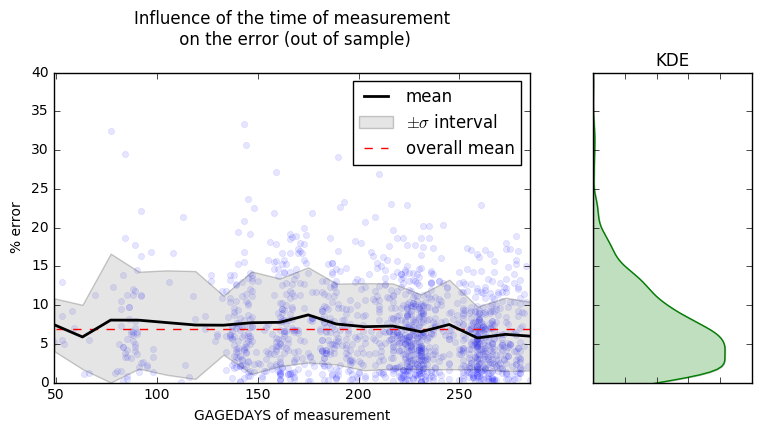

In [32]:
fig = plt.figure(figsize=(9,4))
gs = gridspec.GridSpec(1,2,width_ratios=[3,1])

ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

sns.regplot(x=t,y=pct_error, scatter_kws={'alpha':0.1},fit_reg=False,ax=ax)
ax.plot(reescaled_x,pct_error_binned_df['mean'],label='mean',lw=2,color='k')
ax.fill_between(reescaled_x, pct_error_binned_df['lower'], pct_error_binned_df['upper'], 
                 facecolor='grey', alpha=0.2, label=r'$\pm \sigma$ interval')
ax.set_xlim(t.min(),t.max())
ax.set_ylim(0,40)
ax.set_xlabel('GAGEDAYS of measurement')
ax.set_ylabel('% error')
ax.set_title('Influence of the time of measurement\n on the error (out of sample)\n')
ax.hlines(mean_pct_error,xmin=0,xmax=350,colors='r',linestyles='dashed',label='overall mean')
ax.legend()

sns.kdeplot(pct_error, vertical=True,legend=False, shade=True, lw=1, ax=ax2)
ax2.set_title('KDE')
ax2.set_ylabel('')
ax2.set_ylim(0,40)
ax2.set_xlim(0,0.1)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.show();

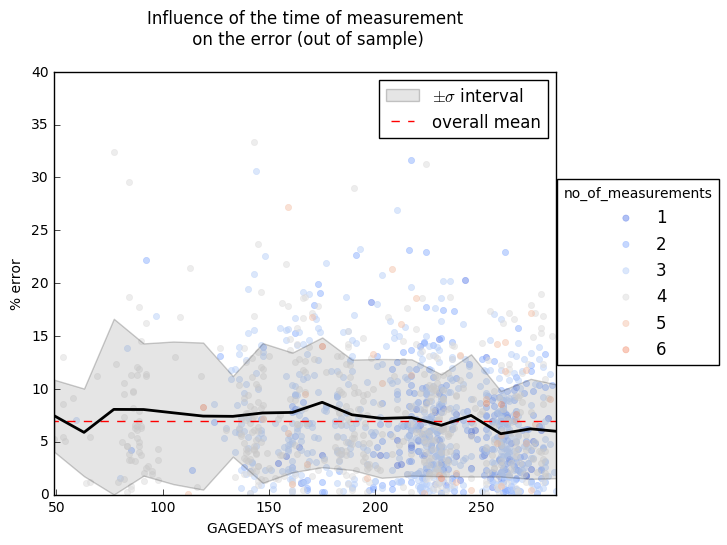

In [33]:
ax = sns.lmplot(x='t',y='pct_error', hue='no_of_measurements', data=data_plot, fit_reg=False,
          scatter_kws={'alpha':0.5}, palette=sns.color_palette("coolwarm", 7), aspect=1.2).ax
ax.plot(reescaled_x,pct_error_binned_df['mean'],label='mean',lw=2,color='k')
ax.fill_between(reescaled_x, pct_error_binned_df['lower'], pct_error_binned_df['upper'], 
                 facecolor='grey', alpha=0.2, label=r'$\pm \sigma$ interval')
ax.set_xlim(t.min(),t.max())
ax.set_ylim(0,40)
ax.set_xlabel('GAGEDAYS of measurement')
ax.set_ylabel('% error')
ax.set_title('Influence of the time of measurement\n on the error (out of sample)\n')
ax.hlines(mean_pct_error,xmin=0,xmax=350,colors='r',linestyles='dashed',label='overall mean')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[-2:],labels=labels[-2:])
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True);

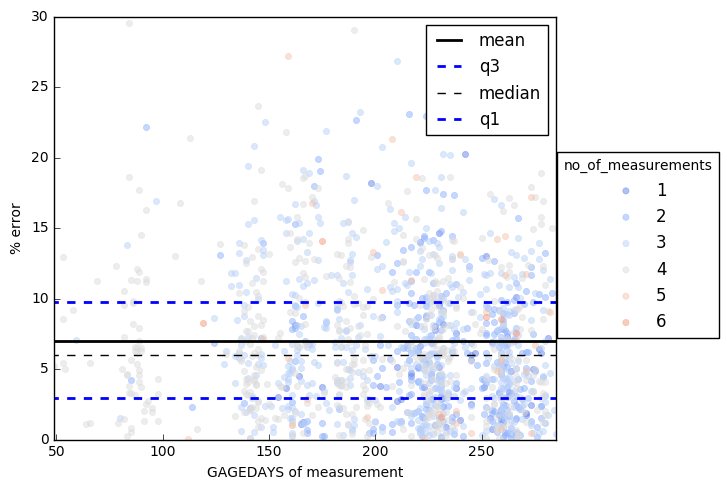

In [34]:
ax = sns.lmplot(x='t',y='pct_error', hue='no_of_measurements', data=data_plot, fit_reg=False,
          scatter_kws={'alpha':0.5}, palette=sns.color_palette("coolwarm", 7), aspect=1.2).ax
ax.set_ylim(0,30)
ax.set_xlim(t.min(),t.max())
ax.set_xlabel('GAGEDAYS of measurement')
ax.set_ylabel('% error')
ax.hlines(mean_pct_error,xmin=0,xmax=350,colors='k',label='mean', lw=2)
ax.hlines(data_plot['pct_error'].quantile(0.75),xmin=0,xmax=350,colors='b',linestyles='dashed',label='q3', lw=2)
ax.hlines(data_plot['pct_error'].quantile(0.5),xmin=0,xmax=350,colors='k',linestyles='dashed',label='median')
ax.hlines(data_plot['pct_error'].quantile(0.25),xmin=0,xmax=350,colors='b',linestyles='dashed',label='q1', lw=2)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[-4:],labels=labels[-4:])
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True);

In [35]:
time.time() - start

312.8407373428345

In [36]:
print('Latest execution: %s' % pd.datetime.now())

Latest execution: 2016-11-29 13:34:22.610985
